In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [2]:
to_drop = [
    'median_sentiment_clean', 'average_sentiment_clean','name','name', 'description',
    'median_sentiment_accurate', 'average_sentiment_accurate', 'median_sentiment_checkin',
    'average_sentiment_checkin', 'median_sentiment_communication', 'average_sentiment_communication',
    'median_sentiment_location', 'average_sentiment_location', 'median_sentiment_value',
    'average_sentiment_value', 'median_sentiment_overall', 'average_sentiment_overall',
    'comments','neighborhood_overview','host_about','host_listings_count','neighbourhood_group_cleansed',
    'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value','neighbourhood','listing_id'
]
columns_to_check = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'median_sentiment_clean', 'average_sentiment_clean',
    'median_sentiment_accurate', 'average_sentiment_accurate', 'median_sentiment_checkin',
    'average_sentiment_checkin', 'median_sentiment_communication', 'average_sentiment_communication',
    'median_sentiment_location', 'average_sentiment_location', 'median_sentiment_value',
    'average_sentiment_value', 'median_sentiment_overall', 'average_sentiment_overall'
]
y_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value']

In [6]:
df = pd.read_csv('./Data/cleaned_with_sentiment_scores_gt20_fuzzy.csv').convert_dtypes()
df = df.dropna(subset=y_columns)
df = df[(df[columns_to_check] != 0).all(axis=1)].reset_index()
y_df = df[y_columns].copy()
df.drop(columns=to_drop,inplace=True)
df['amenities'] = df['amenities'].fillna('').apply(lambda x: len(x.split()))
zero_replace = [
    'host_response_rate','host_acceptance_rate',
    'host_is_superhost','bathrooms','bedrooms','beds','price'
]
df[zero_replace] = df[zero_replace].fillna(0)
df['host_response_time'] = df['host_response_time'].fillna('')
df.drop(columns=['index'],inplace=True)


In [8]:
classification_fields = ["neighbourhood_cleansed", "property_type", "room_type","host_response_time","host_verifications"]
df[classification_fields].applymap(lambda x: x.replace(' ','_'))
encoded_df = pd.DataFrame()
for field in classification_fields:
    encoder = OneHotEncoder()
    df[field] = df[field].apply(lambda x: x.lower())
    ohe = pd.DataFrame(data=encoder.fit_transform(df[[field]]).toarray(), columns=encoder.categories_[0])
    encoded_df = pd.concat([encoded_df, ohe], axis=1)

df.drop(columns=classification_fields,inplace=True)
encoded_df.columns= encoded_df.columns.astype(str)

/tmp/ipykernel_54336/3175533188.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[classification_fields].applymap(lambda x: x.replace(' ','_'))


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.concat([df.reset_index(),encoded_df.reset_index()],axis=1)
df.drop(columns=['index'],inplace=True)
df = pd.DataFrame(scaler.fit_transform(df),columns = df.columns)

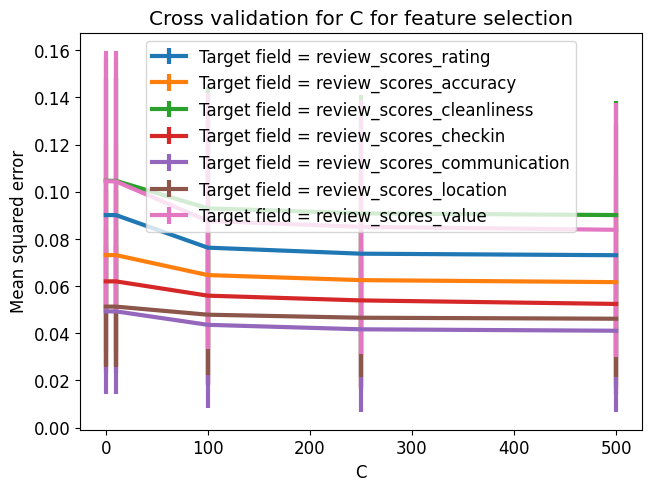

In [37]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
X = df


for index, score_type in enumerate(y_df.columns):
    kf = KFold(n_splits=5)
    mean_error = []
    std_error = []

    c_range = [0.1, 10, 100, 250, 500]
    for C in c_range:
        model = Lasso(alpha=1 / (2 * C), max_iter=100000)
        fold = []

        for train, test in kf.split(X):
            model.fit(X.iloc[train], y_df[score_type].iloc[train])
            predictions = model.predict(X.iloc[test])
            fold.append(mean_squared_error(y_df[score_type].iloc[test], predictions))

        mean_error.append(np.array(fold).mean())
        std_error.append(np.array(fold).std())

    plt.errorbar(c_range, mean_error, yerr=std_error, linewidth=3, label=f"Target field = {score_type}")

plt.rc('font', size=12)
plt.rcParams['figure.constrained_layout.use'] = True
plt.title("Cross validation for C for feature selection")
plt.xlabel("C")
plt.ylabel("Mean squared error")
plt.legend()
plt.show()

In [31]:
weights_df = pd.DataFrame(columns=y_df.columns, index=X.columns)
# c value of 500 gave best results
for index, score_type in enumerate(y_df.columns):
    print("     for " + score_type)
    y = y_df[score_type]
    model = Lasso(alpha=1 / (2 * 100))
    model.fit(X, y)
    weights_df[score_type] = model.coef_

     for review_scores_rating
     for review_scores_accuracy
     for review_scores_cleanliness
     for review_scores_checkin
     for review_scores_communication
     for review_scores_location
     for review_scores_value


In [40]:
important_features = {}
for category in weights_df.columns:
    important_features[category] = weights_df[weights_df[category] != 0].index.to_list()

In [60]:
for key,value in important_features.items():
    print(key)

review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value


In [58]:
%%capture
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
import numpy as np
models = {
    "Ridge": Ridge(),
    "DummyRegressor": DummyRegressor()
}

scoring = make_scorer(mean_squared_error, greater_is_better=False)
# Define hyperparameters
param_grids = {
    "Ridge": {
        'alpha':[.00001,.0001,.001,.01,.1,1,10],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
    },
    "DummyRegressor":{
        'strategy': ['mean','median'],
    }
}

# Perform grid search with cross-validation and evaluate each model
results = []
for key,value in important_features.items():
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X[value], y_df[key], test_size=0.2,random_state=42)
    for name, model in models.items():
            print(f"Training {name}...")
            grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name],scoring=scoring,cv=5, n_jobs=-1, verbose=0)
            grid_search.fit(X_train, y_train)
            
            best_params = grid_search.best_params_
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            results.append({
                'Model': name,
                'Best Params': best_params,
                'MSE': mse,
                'MAE': mae,
                'R^2': r2,
                'Category': key,
            })
        
# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
results_df.to_csv('multi_model_evaluation_all_categories_cv5.csv');


In [61]:
results_df

,Model,Best Params,MSE,MAE,R^2,Category
0,Ridge,"{'alpha': 1, 'solver': 'lsqr'}",0.049146,0.155153,0.218566,review_scores_rating
1,DummyRegressor,{'strategy': 'mean'},0.062913,0.182328,-0.000330,review_scores_rating
2,Ridge,"{'alpha': 1, 'solver': 'saga'}",0.041074,0.135909,0.179563,review_scores_accuracy
3,DummyRegressor,{'strategy': 'mean'},0.050095,0.154983,-0.000638,review_scores_accuracy
4,Ridge,"{'alpha': 0.01, 'solver': 'sag'}",0.061465,0.184112,0.157202,review_scores_cleanliness
5,DummyRegressor,{'strategy': 'mean'},0.072943,0.204029,-0.000186,review_scores_cleanliness
6,Ridge,"{'alpha': 10, 'solver': 'lsqr'}",0.042969,0.132409,0.145809,review_scores_checkin
7,DummyRegressor,{'strategy': 'mean'},0.050309,0.144821,-0.000102,review_scores_checkin
8,Ridge,"{'alpha': 1, 'solver': 'sag'}",0.027918,0.104749,0.203015,review_scores_communication
9,DummyRegressor,{'strategy': 'mean'},0.035055,0.124471,-0.000727,review_scores_communication
